In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

files = glob.glob('D:/T5_ClosedLoop/*')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### train linear regressor on day 0, test on days 1, 2, ... 

- use 5 ms windows of binned FR activity to estimate cursorErr signal

In [38]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [57]:
dat      = DataStruct(files[2])
window   = 5

n_chans    = dat.TX.shape[1]
timepoints = dat.TX.shape[0]
targets    = (dat.targetPos - dat.cursorPos)[:(-1 * window), :]
features   = rolling_window(dat.TX, window = 5).mean(axis = 2)[:(-1 * window), :]

lr         = LinearRegression()
normalizer = StandardScaler()
decoder    = Pipeline([('scaler', StandardScaler()), ('regressor', lr)])
scores = cross_val_score(decoder, features, targets, cv = 10)
print('10-fold cross-validation scores: ', scores)
decoder.fit(features, targets)

10-fold cross-validation scores:  [0.29895628 0.30751637 0.28511905 0.30884799 0.34540683 0.31440408
 0.37736908 0.3703269  0.33784328 0.34451229]


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [58]:
date   = list()
scores = list() 
for i in range(3, 13):
    file = files[i]
    dat  = DataStruct(file)
    date.append(file.split('t5.')[1].split('.mat')[0])
    
    n_chans    = dat.TX.shape[1]
    timepoints = dat.TX.shape[0]
    targs      = (dat.targetPos - dat.cursorPos)[:(-1 * window), :]
    features   = rolling_window(dat.TX, window = 5).mean(axis = 2)[:(-1 * window), :]
    
    scores.append(decoder.score(features, targs))
    

Text(0.5, 1.0, 'Decoder performance across time (no adaptation)')

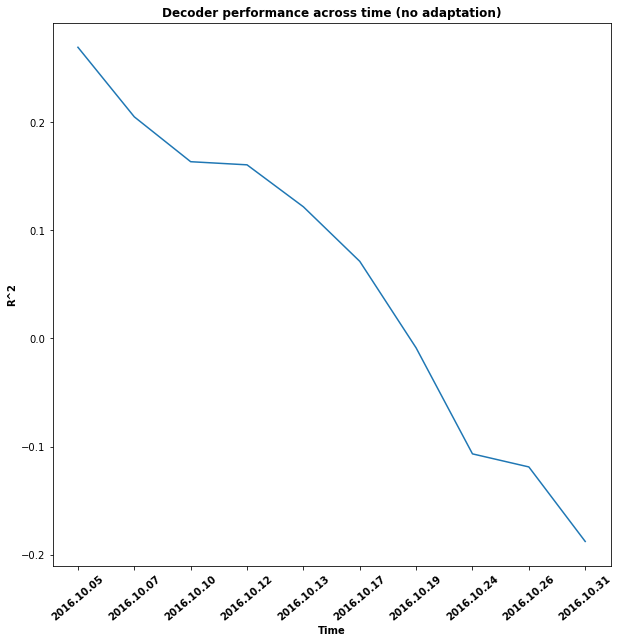

In [86]:
figSize(10, 10)

plt.plot(scores)
plt.xlabel('Time', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
plt.xticks(np.arange(len(date)), date, rotation = 40, fontweight = 'bold')
plt.title('Decoder performance across time (no adaptation)', fontweight = 'bold')

In [81]:
decoder['regressor'].intercept_

array([2.60016985, 8.59484223])